# Load Required Libraries and Datasets
Quantium Virtual Internship - Task 2: Store Trial Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t as t_dist
import warnings
warnings.filterwarnings("ignore")

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
# Load data
data = pd.read_csv(r"C:\Users\SARTMAN\Documents\Data Science\Tableau\Forage\Quantum\Task 2\QVI_data.csv")

# Convert DATE column to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Create a "YEARMONTH" column for analysis
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Define Key Metrics for Each Store Per Month

In [3]:
metrics = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
    nTxnPerCust=('TXN_ID', pd.Series.nunique),
    nChipsPerTxn=('PROD_QTY', 'sum'),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / len(x))
).reset_index()

# Select stores that were operational for the full pre-trial period (Feb 2018 - Jan 2019)
full_obs_stores = metrics.groupby('STORE_NBR')['YEARMONTH'].nunique()
valid_stores = full_obs_stores[full_obs_stores == 12].index
pre_trial_metrics = metrics[(metrics['YEARMONTH'] < 201902) & (metrics['STORE_NBR'].isin(valid_stores))]

In [4]:
temp = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales = ('TOT_SALES', 'sum'),
    nCustomers = ('LYLTY_CARD_NBR', pd.Series.nunique),
    nTxns = ('TXN_ID', pd.Series.nunique),
    totalChips = ('PROD_QTY', 'sum')
).reset_index()
temp['nTxnPerCust'] = temp['nTxns'] / temp['nCustomers']
temp['nChipsPerTxn'] = temp['totalChips'] / temp['nTxns']
temp['avgPricePerUnit'] = temp['totSales'] / temp['totalChips']
# Keep only the necessary columns
measureOverTime = temp[['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers', 
                        'nTxnPerCust', 'nChipsPerTxn', 'avgPricePerUnit']]
measureOverTime = measureOverTime.sort_values(['STORE_NBR', 'YEARMONTH'])

# Filter Pre-Trial Measures

In [5]:
# Identify stores with full observation (12 months pre-trial)
store_month_counts = measureOverTime.groupby('STORE_NBR')['YEARMONTH'].nunique()
storesWithFullObs = store_month_counts[store_month_counts == 12].index
preTrialMeasures = measureOverTime[(measureOverTime['YEARMONTH'] < 201902) & 
                                   (measureOverTime['STORE_NBR'].isin(storesWithFullObs))]

# Function to Calculate Correlation Between Stores

In [6]:
def calculate_correlation(input_table, metric_col, store_comparison):
    """Calculate the Pearson correlation of the given metric between the trial store and each other store."""
    corr_list = []
    store_numbers = input_table['STORE_NBR'].unique()
    for store in store_numbers:
        if store != store_comparison:
            trial_series = input_table[input_table['STORE_NBR'] == store_comparison][metric_col]
            control_series = input_table[input_table['STORE_NBR'] == store][metric_col]
            if len(trial_series) > 1 and len(control_series) > 1:
                corr_value = trial_series.corr(control_series)
            else:
                corr_value = np.nan
            corr_list.append({'Store1': store_comparison, 'Store2': store, 'corr_measure': corr_value})
    return pd.DataFrame(corr_list)

# Function to Calculate Magnitude Distance Between Stores

In [7]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """
    Calculate a standardized magnitude distance between the trial store and each other store.
    For each month in the pre-trial period, compute the absolute difference; then standardize
    the differences (so that they range from 0 to 1) and take the average.
    """
    magnitude_results = []
    trial_months = input_table[input_table['STORE_NBR'] == store_comparison]['YEARMONTH'].unique()
    store_numbers = input_table['STORE_NBR'].unique()
    for store in store_numbers:
        if store != store_comparison:
            diffs = []
            for m in trial_months:
                trial_val = input_table[(input_table['STORE_NBR'] == store_comparison) & (input_table['YEARMONTH'] == m)][metric_col]
                control_val = input_table[(input_table['STORE_NBR'] == store) & (input_table['YEARMONTH'] == m)][metric_col]
                if not trial_val.empty and not control_val.empty:
                    diff = abs(trial_val.values[0] - control_val.values[0])
                    diffs.append(diff)
            if diffs:
                diffs = np.array(diffs)
                # Standardize differences across months for this trial-control pair
                if diffs.max() == diffs.min():
                    std_diffs = np.zeros_like(diffs)
                else:
                    std_diffs = (diffs - diffs.min()) / (diffs.max() - diffs.min())
                mag_measure = 1 - np.mean(std_diffs)
                magnitude_results.append({'Store1': store_comparison, 'Store2': store, 'mag_measure': mag_measure})
    return pd.DataFrame(magnitude_results)

# Find Best Control Stores

In [8]:
trial_stores = [77, 86, 88]
control_store_dict = {}

for trial in trial_stores:
    print(f"\nFinding control store for trial store {trial}...")
    # Calculate correlations for totSales and nCustomers
    corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial)
    corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial)
    # Calculate magnitude distances for totSales and nCustomers
    mag_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial)
    mag_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial)
    # Merge correlation and magnitude scores and compute combined scores (weight=0.5 each)
    score_nSales = pd.merge(corr_nSales, mag_nSales, on=['Store1','Store2'])
    score_nSales['scoreNSales'] = 0.5 * score_nSales['corr_measure'] + 0.5 * score_nSales['mag_measure']
    score_nCustomers = pd.merge(corr_nCustomers, mag_nCustomers, on=['Store1','Store2'])
    score_nCustomers['scoreNCust'] = 0.5 * score_nCustomers['corr_measure'] + 0.5 * score_nCustomers['mag_measure']
    # Merge the two drivers and take the average as final score
    score_Control = pd.merge(score_nSales[['Store1','Store2','scoreNSales']],
                             score_nCustomers[['Store1','Store2','scoreNCust']],
                             on=['Store1','Store2'])
    score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']
    # Select control store: choose the second highest scoring store (exclude the trial store itself)
    score_for_trial = score_Control[score_Control['Store1'] == trial].sort_values(by='finalControlScore', ascending=False)
    if len(score_for_trial) >= 2:
        control = score_for_trial.iloc[1]['Store2']
    else:
        control = np.nan
    control_store_dict[trial] = control

print("\nSelected Control Stores:")
print(control_store_dict)


Finding control store for trial store 77...

Finding control store for trial store 86...

Finding control store for trial store 88...

Selected Control Stores:
{77: 2.0, 86: 2.0, 88: 2.0}


# Define a Function for Trial Assessment (Sales & Customers)

In [9]:
def trial_assessment(trial_store, control_store, measure_table, metric, measure_label, output_prefix):
    """
    For the given metric (e.g. totSales or nCustomers), assess the trial impact by:
      - Scaling the control store’s pre‐trial performance to match the trial store’s performance.
      - Calculating the percentage difference during the trial period.
      - Computing t‐values (using pre‐trial variability) and plotting trends.
    """
    # Define trial period: March 2019 to June 2019 (YEARMONTH from 201903 to 201906)
    trial_period = measure_table[(measure_table['YEARMONTH'] >= 201903) & (measure_table['YEARMONTH'] <= 201906)]
    trial_data = trial_period[trial_period['STORE_NBR'] == trial_store]
    control_data = trial_period[trial_period['STORE_NBR'] == control_store]
    
    # Calculate scaling factor using pre-trial data (YEARMONTH < 201902)
    pre_trial = measure_table[measure_table['YEARMONTH'] < 201902]
    trial_pre_sum = pre_trial[pre_trial['STORE_NBR'] == trial_store][metric].sum()
    control_pre_sum = pre_trial[pre_trial['STORE_NBR'] == control_store][metric].sum()
    scaling_factor = trial_pre_sum / control_pre_sum if control_pre_sum != 0 else 1
    
    # Apply scaling factor to control store's trial period metric
    control_data_scaled = control_data.copy()
    control_data_scaled['scaled_metric'] = control_data_scaled[metric] * scaling_factor
    
    # Merge trial and scaled control data on YEARMONTH
    merged = pd.merge(trial_data[['YEARMONTH', metric]],
                        control_data_scaled[['YEARMONTH', 'scaled_metric']],
                        on='YEARMONTH')
    merged['percentageDiff'] = abs(merged['scaled_metric'] - merged[metric]) / merged['scaled_metric']
    
    # Compute standard deviation of percentage differences in pre-trial period
    pre_trial_merged = pd.merge(
        pre_trial[pre_trial['STORE_NBR'] == trial_store][['YEARMONTH', metric]],
        pre_trial[pre_trial['STORE_NBR'] == control_store][['YEARMONTH', metric]].rename(columns={metric:'control_metric'}),
        on='YEARMONTH'
    )
    pre_trial_merged['pctDiff'] = abs(pre_trial_merged['control_metric'] * scaling_factor - pre_trial_merged[metric]) / (pre_trial_merged['control_metric'] * scaling_factor)
    std_dev = pre_trial_merged['pctDiff'].std()
    
    # Compute t-values for trial period: (observed percentage difference) / std_dev
    merged['tValue'] = merged['percentageDiff'] / std_dev if std_dev != 0 else np.nan
    
    # 95th percentile t-critical value with df = 7 (8 pre-trial months => 7 df)
    t_critical = t_dist.ppf(0.95, df=7)
    
    print(f"\nTrial Assessment for {measure_label} (Trial Store {trial_store} vs Control Store {control_store}):")
    print(merged[['YEARMONTH', metric, 'scaled_metric', 'percentageDiff', 'tValue']])
    print(f"Pre-trial std dev of pct differences: {std_dev:.4f}")
    print(f"95th percentile t-critical (df=7): {t_critical:.4f}")
    
    # For visualization, convert YEARMONTH to a date (using day=1)
    trial_period = trial_period.copy()
    trial_period['TransactionMonth'] = pd.to_datetime(trial_period['YEARMONTH'].astype(str) + "01", format='%Y%m%d')
    # Create a column for Store_type
    trial_period['Store_type'] = np.where(trial_period['STORE_NBR'] == trial_store, "Trial", 
                                           np.where(trial_period['STORE_NBR'] == control_store, "Control", "Other"))
    # For the control store, calculate approximate 5th and 95th confidence bounds (±2 std dev)
    control_plot = trial_period[trial_period['STORE_NBR'] == control_store].copy()
    control_plot['Control_95'] = control_plot[metric] * (1 + 2 * std_dev)
    control_plot['Control_5'] = control_plot[metric] * (1 - 2 * std_dev)
    
    plt.figure()
    for stype, grp in trial_period[trial_period['Store_type'].isin(["Trial", "Control"])].groupby('Store_type'):
        plt.plot(grp['TransactionMonth'], grp[metric], marker='o', label=stype)
    plt.plot(control_plot['TransactionMonth'], control_plot['Control_95'], linestyle='--', color='gray', label='Control 95% CI')
    plt.plot(control_plot['TransactionMonth'], control_plot['Control_5'], linestyle='--', color='gray', label='Control 5% CI')
    plt.xlabel("Month of Operation")
    plt.ylabel(measure_label)
    plt.title(f"{measure_label} by Month: Trial Store {trial_store} vs Control Store {control_store}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_trial_assessment.png")
    plt.show()
    plt.close()
    
    return merged

# 7. Assess Trial Impact for Each Trial Store


--- Analysis for Trial Store 77 ---

Trial Assessment for Total Sales (Trial Store 77 vs Control Store 2.0):
   YEARMONTH  totSales  scaled_metric  percentageDiff    tValue
0     201903     278.5     289.213912        0.037045  0.307258
1     201904     263.5     295.838281        0.109311  0.906643
2     201905     299.3     290.117235        0.031652  0.262527
3     201906     264.7     235.767302        0.122717  1.017839
Pre-trial std dev of pct differences: 0.1206
95th percentile t-critical (df=7): 1.8946


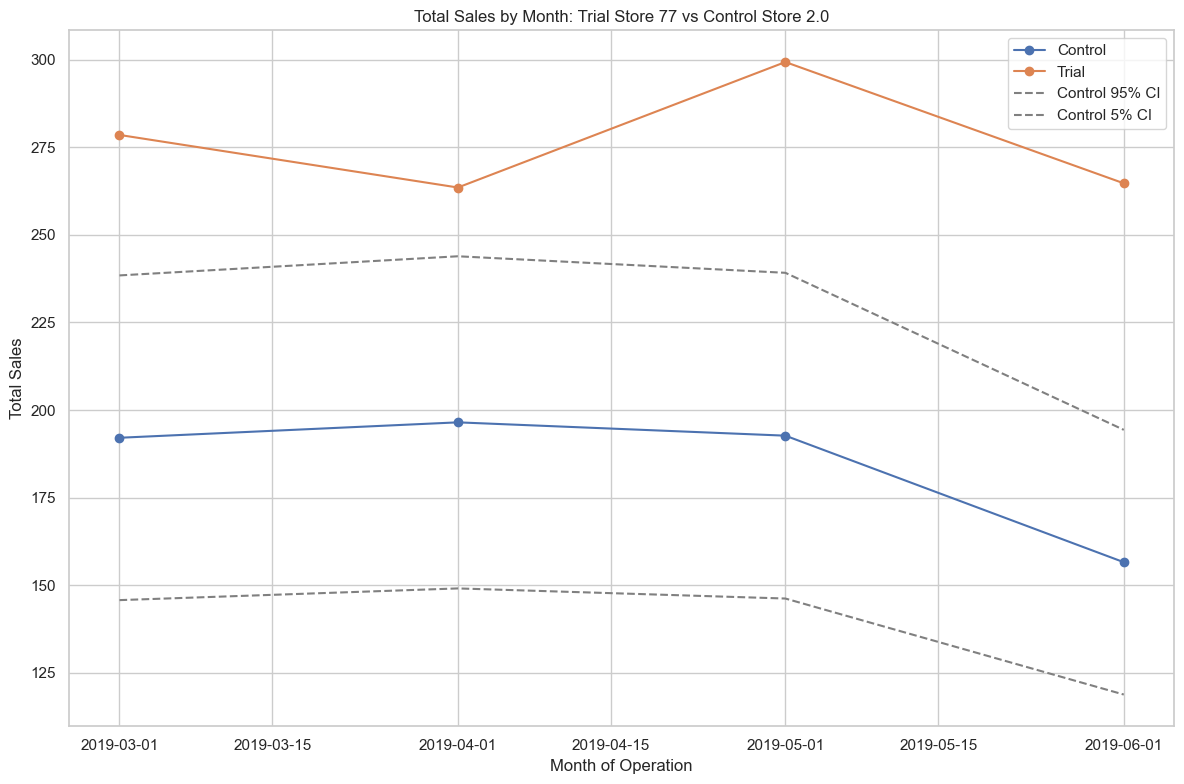


Trial Assessment for Number of Customers (Trial Store 77 vs Control Store 2.0):
   YEARMONTH  nCustomers  scaled_metric  percentageDiff    tValue
0     201903          50      47.268382        0.057790  0.721778
1     201904          47      51.665441        0.090301  1.127839
2     201905          55      52.764706        0.042363  0.529110
3     201906          41      43.970588        0.067559  0.843790
Pre-trial std dev of pct differences: 0.0801
95th percentile t-critical (df=7): 1.8946


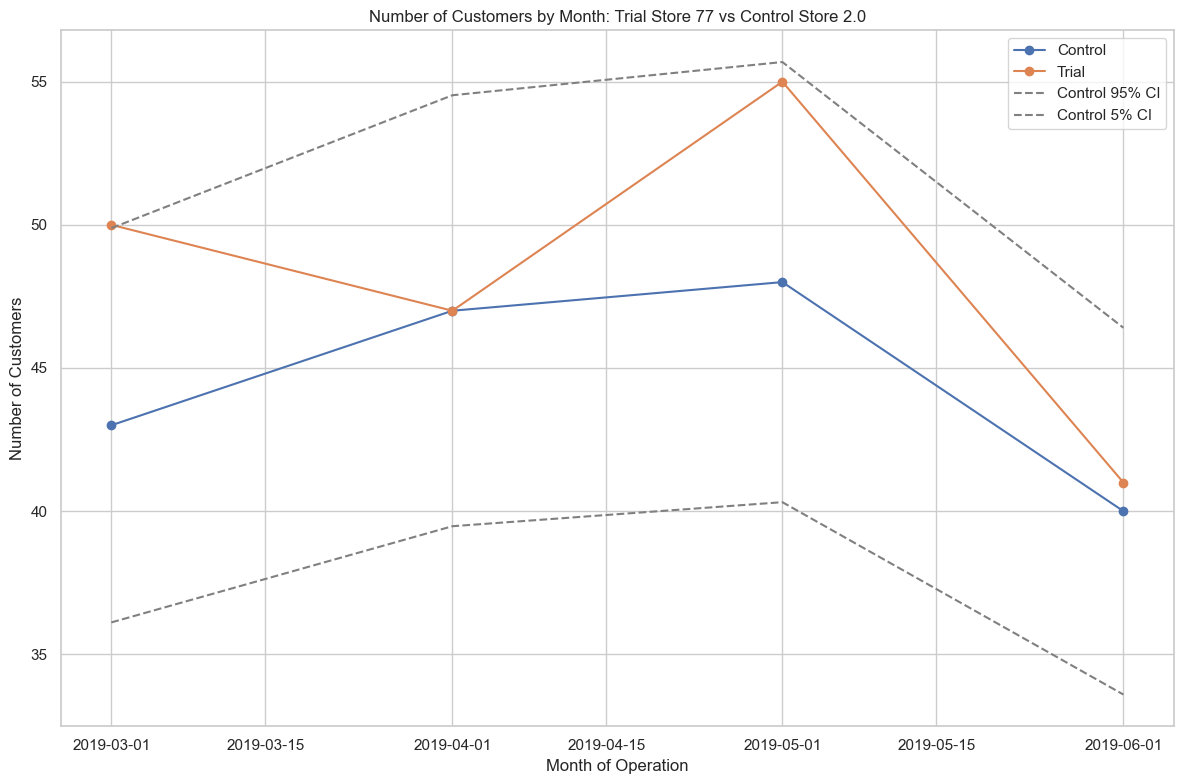


--- Analysis for Trial Store 86 ---

Trial Assessment for Total Sales (Trial Store 86 vs Control Store 2.0):
   YEARMONTH  totSales  scaled_metric  percentageDiff    tValue
0     201903    1026.8    1041.757364        0.014358  0.172681
1     201904     848.2    1065.618542        0.204030  2.453869
2     201905     889.3    1045.011161        0.149004  1.792072
3     201906     838.0     849.241037        0.013237  0.159196
Pre-trial std dev of pct differences: 0.0831
95th percentile t-critical (df=7): 1.8946


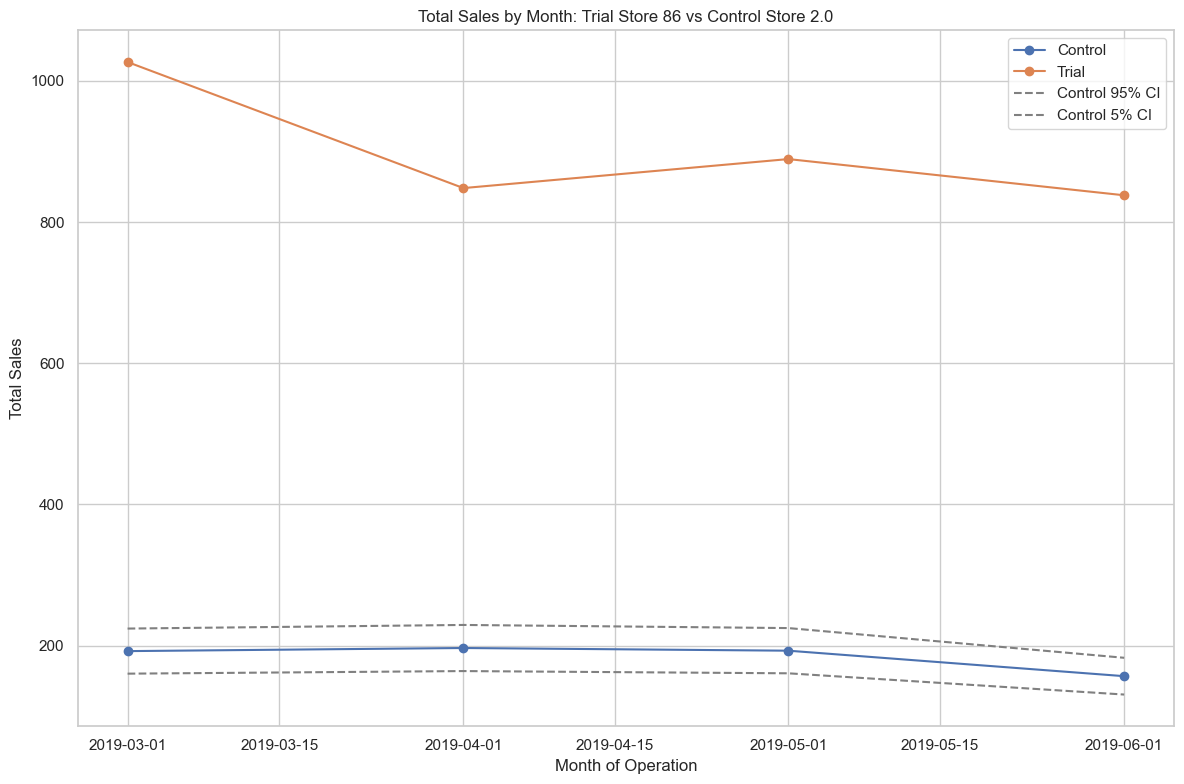


Trial Assessment for Number of Customers (Trial Store 86 vs Control Store 2.0):
   YEARMONTH  nCustomers  scaled_metric  percentageDiff    tValue
0     201903         115       110.1875        0.043676  0.794146
1     201904         105       120.4375        0.128179  2.330651
2     201905         104       123.0000        0.154472  2.808734
3     201906          98       102.5000        0.043902  0.798272
Pre-trial std dev of pct differences: 0.0550
95th percentile t-critical (df=7): 1.8946


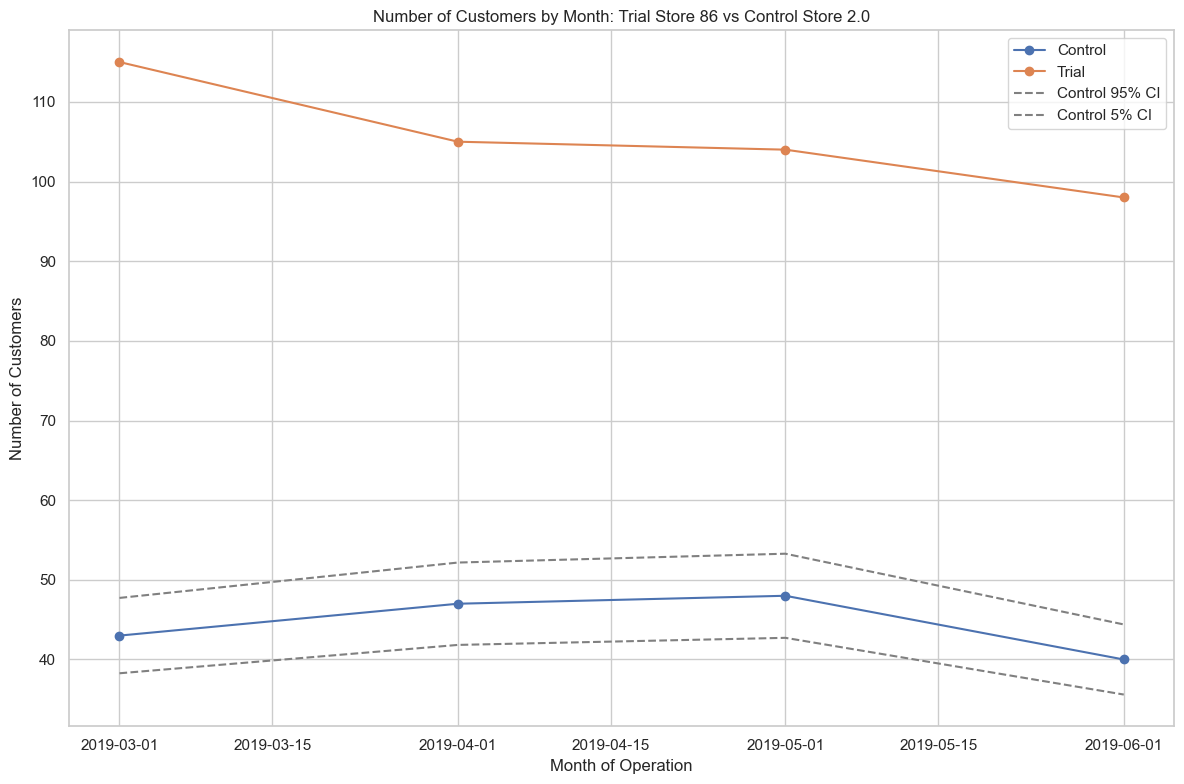


--- Analysis for Trial Store 88 ---

Trial Assessment for Total Sales (Trial Store 88 vs Control Store 2.0):
   YEARMONTH  totSales  scaled_metric  percentageDiff    tValue
0     201903   1477.20    1597.332353        0.075208  1.145801
1     201904   1439.40    1633.918830        0.119050  1.813742
2     201905   1308.25    1602.321418        0.183528  2.796067
3     201906   1354.60    1302.145999        0.040283  0.613710
Pre-trial std dev of pct differences: 0.0656
95th percentile t-critical (df=7): 1.8946


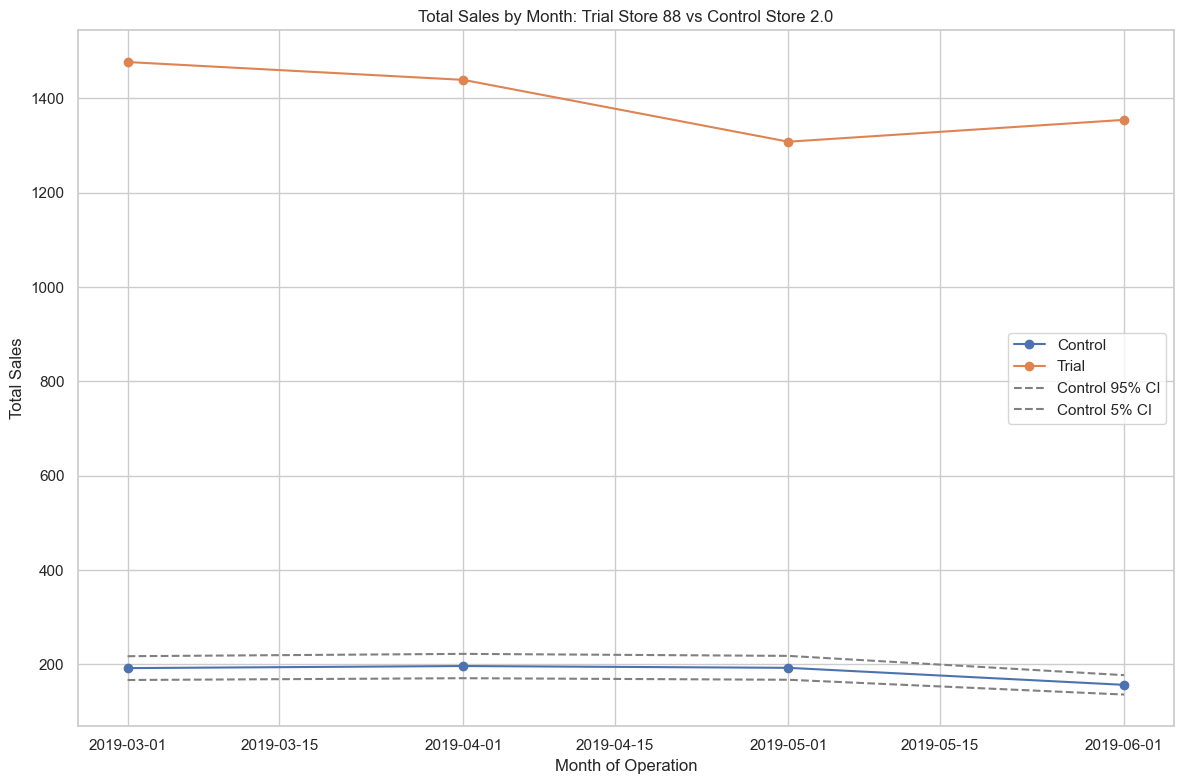


Trial Assessment for Number of Customers (Trial Store 88 vs Control Store 2.0):
   YEARMONTH  nCustomers  scaled_metric  percentageDiff    tValue
0     201903         134     139.117647        0.036786  0.745255
1     201904         128     152.058824        0.158221  3.205382
2     201905         128     155.294118        0.175758  3.560665
3     201906         121     129.411765        0.065000  1.316832
Pre-trial std dev of pct differences: 0.0494
95th percentile t-critical (df=7): 1.8946


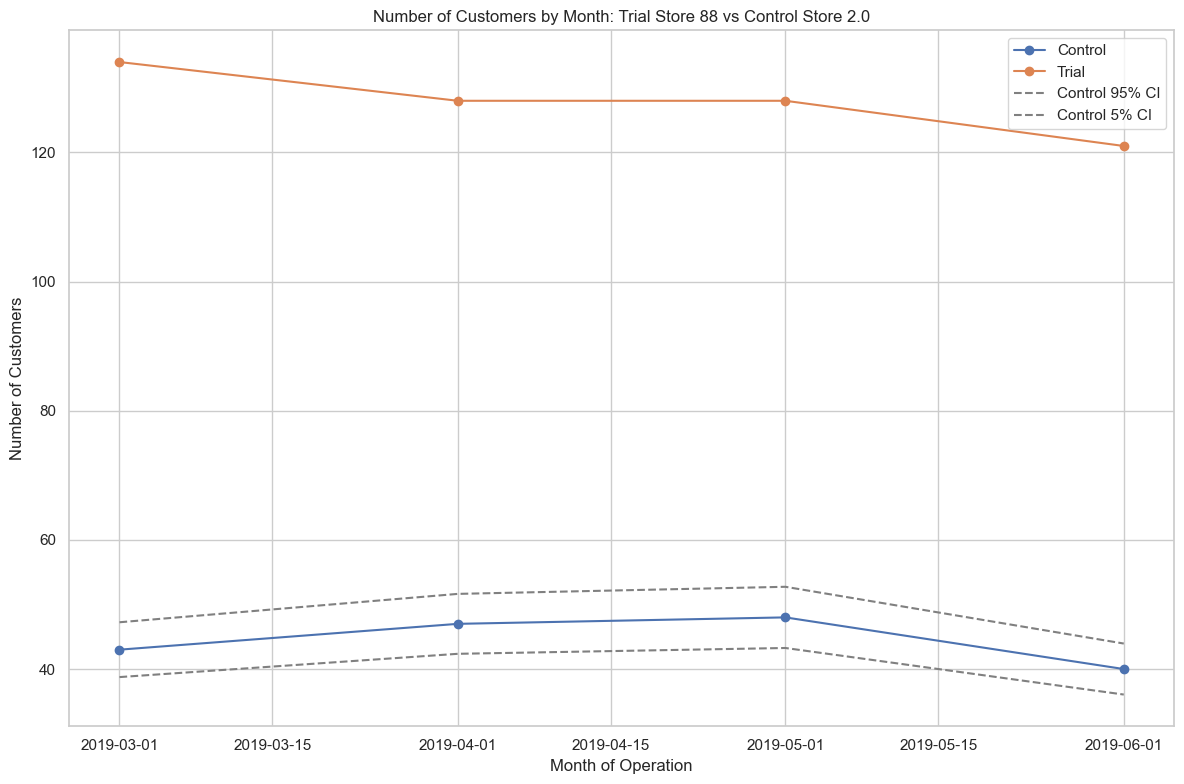

In [10]:
for trial in trial_stores:
    control = control_store_dict.get(trial, np.nan)
    if pd.isna(control):
        print(f"Control store for trial store {trial} not found.")
        continue
    print(f"\n--- Analysis for Trial Store {trial} ---")
    # Assess Total Sales
    sales_assessment = trial_assessment(trial, control, measureOverTime, 'totSales', "Total Sales", f"sales_trial_{trial}")
    # Assess Number of Customers
    cust_assessment = trial_assessment(trial, control, measureOverTime, 'nCustomers', "Number of Customers", f"customers_trial_{trial}")

# Conclusion

In [11]:
print("\nAnalysis complete. Plots and metrics have been saved.")



Analysis complete. Plots and metrics have been saved.
